In [1]:
#importing bunch of libraries that would be needed in future
import pandas as pd
import numpy as np
import gc,os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pickle
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold

 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.chdir('/content/gdrive/My Drive/santander_transcation_prediction')

In [88]:
#train
df=pd.read_csv("train.csv.zip")
X_train=df.drop(['target','ID_code'],axis=1)
Y_train=df['target']


In [5]:
#test
X_test=pd.read_csv("test.csv.zip")
X_test.drop('ID_code',axis=1,inplace=True)


In [6]:
col=[f'var_{i}' for i in range(200)]

In [7]:
target_0_index=df[df['target']==0].index
target_1_index=df[df['target']==1].index
#del df; gc.collect()

In [8]:
#concating train & real test dataset
real_test_index=pickle.load(open('real_test_index.pkl','rb'))
X_conc=pd.concat([X_train,X_test.loc[real_test_index]],ignore_index=True)

**count encoding**

In [89]:
FE=dict()  #storing information for feature engineering
for c in tqdm(col):                                        # iterating over columns
  freq=X_conc[c].value_counts().to_dict()                  #frequency of each value in that feature  
  FE[c]=freq                                               # storing in a dictionary
                                               
  X_train[f'{c}_freq']=X_train[c].map(freq).fillna(1)      # Getting new feature for train data      
  #X_test[f'{c}_freq']=X_test[c].map(freq).fillna(1)

100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


In [97]:
#dumping the file to drive which creates new feature based on given raw data
pickle.dump(FE,(open('STP_Dumping/Feature_engineering.pkl','wb')))

In [98]:
X_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160_freq,var_161_freq,var_162_freq,var_163_freq,var_164_freq,var_165_freq,var_166_freq,var_167_freq,var_168_freq,var_169_freq,var_170_freq,var_171_freq,var_172_freq,var_173_freq,var_174_freq,var_175_freq,var_176_freq,var_177_freq,var_178_freq,var_179_freq,var_180_freq,var_181_freq,var_182_freq,var_183_freq,var_184_freq,var_185_freq,var_186_freq,var_187_freq,var_188_freq,var_189_freq,var_190_freq,var_191_freq,var_192_freq,var_193_freq,var_194_freq,var_195_freq,var_196_freq,var_197_freq,var_198_freq,var_199_freq
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,...,2,25,3,5,1,2,22,2,3,34,9,4,2,2,2,7,3,2,3,4,3,7,3,4,2,1,6,3,4,8,3,8,9,4,9,5,5,14,5,2
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,...,3,38,5,1,2,3,31,1,11,24,1,1,1,2,2,4,1,5,1,1,3,5,1,4,2,5,4,1,5,14,8,5,9,2,4,4,4,21,6,2
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,10.8917,0.9003,...,2,33,8,1,5,5,23,2,6,20,3,3,1,4,1,5,2,2,2,6,4,4,2,2,4,5,4,1,1,3,4,5,6,2,2,2,3,12,4,2
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,9.1738,0.6665,...,1,13,4,2,1,7,16,1,3,32,1,2,3,1,3,3,2,3,1,6,1,10,6,3,2,3,8,1,8,7,2,3,6,4,4,8,5,4,2,2
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,19.3038,1.4450,...,2,46,11,1,1,1,31,1,4,39,2,3,1,3,2,3,3,1,4,6,4,8,3,1,2,2,3,1,2,10,3,8,1,1,1,9,5,9,2,2


In [93]:
X_train.shape

(200000, 400)

In [99]:
#raw+generated features
columns_=X_train.columns

In [95]:
# LGBM PARAMETERS
param = {
    'learning_rate': 0.01,
    'num_leaves': 4,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 0.4,
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'max_depth': -1,
    'min_sum_hessian_in_leaf': 10.0,
    'objective': 'binary',
    'verbosity': 1,
    'num_threads':2
    }

In [96]:
#cross validation is used to improve the perfomance 
kfolds = StratifiedKFold(n_splits=10, shuffle=False, random_state=40000)
models=dict()  # It will store trained lgbm model on different train data
n_fold=0
for train_index,valid_index in kfolds.split(X_train.values, Y_train.values):

    print("Fold :",n_fold)
    
    #Dataset
    train_sample = lgb.Dataset(X_train.iloc[train_index][columns_], label=Y_train.iloc[train_index])
    valid_sample = lgb.Dataset(X_train.iloc[valid_index][columns_], label=Y_train.iloc[valid_index])
 
    #lgb classifier : training untill validation score does not increase after 3000 rounds
    num_round = 500000
    lgb_clf= lgb.train(param, train_sample, num_round,valid_sets = [train_sample, valid_sample], verbose_eval=1000, early_stopping_rounds = 3000)
    
    models[f'lgb_clf_{n_fold}']=lgb_clf

    n_fold+=1

Fold : 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.842266	valid_1's auc: 0.831419
[2000]	training's auc: 0.876015	valid_1's auc: 0.863009
[3000]	training's auc: 0.890909	valid_1's auc: 0.876737
[4000]	training's auc: 0.89995	valid_1's auc: 0.885477
[5000]	training's auc: 0.906098	valid_1's auc: 0.890979
[6000]	training's auc: 0.910488	valid_1's auc: 0.894986
[7000]	training's auc: 0.9139	valid_1's auc: 0.89797
[8000]	training's auc: 0.9166	valid_1's auc: 0.900063
[9000]	training's auc: 0.918905	valid_1's auc: 0.901872
[10000]	training's auc: 0.920903	valid_1's auc: 0.903101
[11000]	training's auc: 0.922753	valid_1's auc: 0.904106
[12000]	training's auc: 0.924454	valid_1's auc: 0.90485
[13000]	training's auc: 0.926107	valid_1's auc: 0.905363
[14000]	training's auc: 0.927705	valid_1's auc: 0.905991
[15000]	training's auc: 0.929238	valid_1's auc: 0.90621
[16000]	training's auc: 0.930738	valid_1's auc: 0.906553
[17000]	training's auc: 0.932148

In [100]:
# dumping trained model
pickle.dump(models,(open('STP_Dumping/models.pkl','wb')))

In [ ]:
#Loading save files from drive
# FE=pickle.load(open('STP_Dumping/Feature_engineering.pkl','rb'))
# models=pickle.load(open('STP_Dumping/models.pkl','rb'))

In [121]:
def get_prediction(x):  #shape of x=(1,d) ,where d=number of raw features

  # freq encoding for each feature
  x_freq=np.zeros(x.shape[1])   #This will be used to store newly generated features
  i=0
  for c in col:
    x_=x[0,i]             # Getting value at feature_c
    try:
      x_freq[i]=FE[c][x_] # getting frequency of the value present at feature_c
    except:
      x_freq[i]=1         # If any 'value' that is not present in train data for that feature then give it frequency =1
    #x_freq[i]=pd.Series(x[0,i]).map(FE[c]).fillna(1)
    i+=1

  x=np.concatenate((x,x_freq.reshape(1,-1)),axis=1)  # orignal and new features
  
  #Predictions
  pred=np.zeros(len(x))
  for clf in models.values():    #for each trained lgbm classifier
    pred+=clf.predict(x)        #returns probablity value
  final_prediction=pred/len(models) #averaging predictions fro different lgbm classifier
  y_pred_label=np.where(final_prediction<0.5,0,1)  #Getting label from probablity value

  return y_pred_label




In [131]:
def get_perfomance(x,y):   # x should be ndarray , y can be "pandas.core.series.Series" or "ndarray"

  # freq encoding for each feature
  x_freq=np.zeros(x.shape)   #This will be used to store newly generated features
  i=0
  for c in tqdm(col):
    x_freq[:,i]=pd.Series(x[:,i]).map(FE[c]).fillna(1).values
    i+=1

  #concatation
  x=np.concatenate((x,x_freq),axis=1)  # orignal and new features

  #Predictions
  pred=np.zeros(len(x))
  for clf in models.values():    #for each trained lgbm classifier
    pred+=clf.predict(x)        #returns probablity value
  final_prediction=pred/len(models) #averaging predictions fro different lgbm classifier
  #y_pred_label=np.where(final_prediction<0.5,0,1)  #Getting label from probablity value

  
  auc_score=roc_auc_score(y,final_prediction)

  return auc_score




### Kaggle score in top 5%

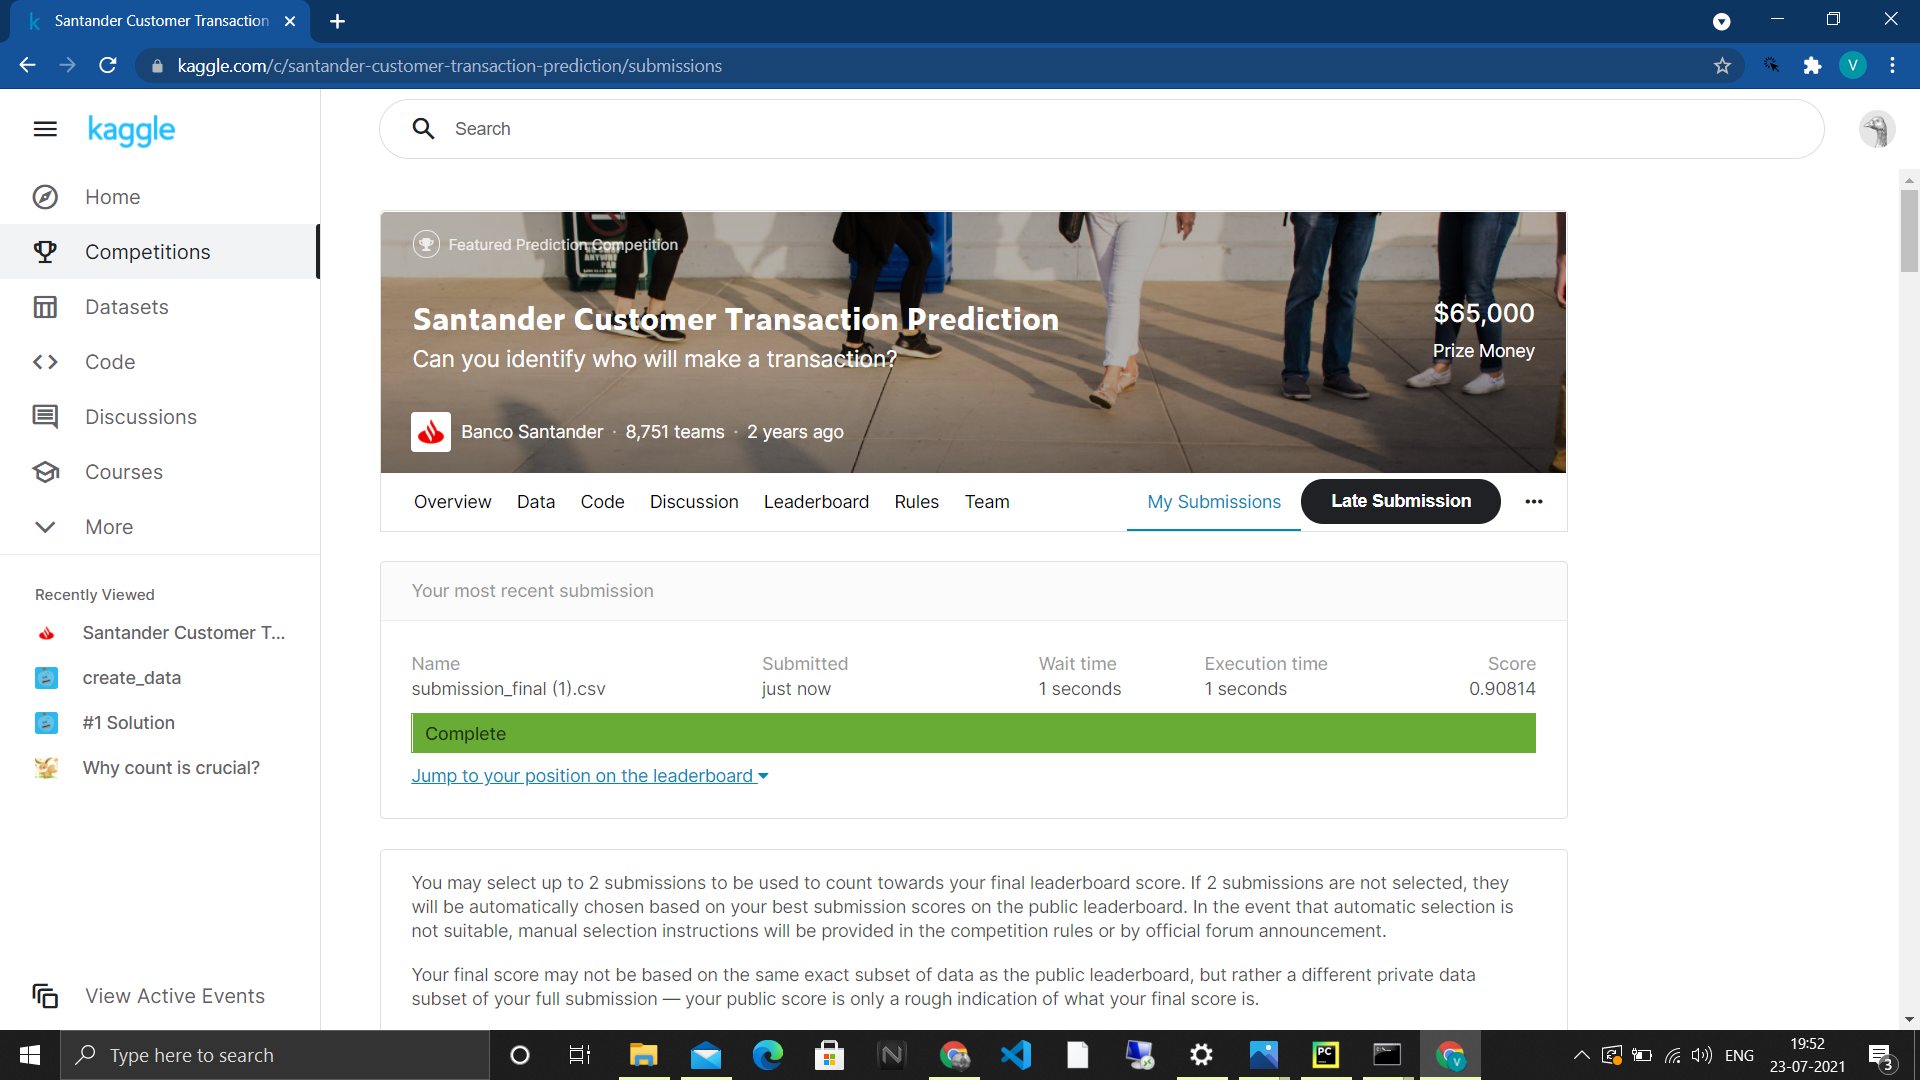

### **Index of  fake data in test dataset**

In [ ]:
col=[f'var_{i}' for i in range(200)]        #All 200 column names
for col in tqdm(col):
  count=test_df[col].value_counts()               #return a series containing count of unique values
  uniques=count.index[count==1]                   #elements which has count=1
  test_df[col+'_uniq']=test_df[col].isin(uniques) #Creating new features having value '1' for if the element is unique among all the values 
                                                  #in its column else '0'

#It will create a feature  'any_unique'  
#which will assign value of 1 if any of the {var_0,var_1,.....var_199} features have unique entries in that row else 0
test_df['any_unique']=test_df[[col +'_uniq' for col in col]].any(axis=1)
  

100%|██████████| 200/200 [00:05<00:00, 36.56it/s]


In [ ]:
col=[f'var_{i}' for i in range(200)]        #All 200 column names
for c in tqdm(col):
  count=test_df[c].value_counts()               #return a series containing count of unique values               
  test_df[c+'_is_uniq']=test_df[c].map(count)      #Creating new features having value '1' for if the element is unique among all the values 
                                                  #in its column else '0'



100%|██████████| 200/200 [00:06<00:00, 32.28it/s]


In [ ]:
#Return true if sample has any  value with count==1 else False
def UNIQUE(value):
  is_uniq=np.any(value==1)
  return is_uniq

In [ ]:
test_df['uniq']=test_df[[c+'_is_uniq' for c in col]].apply(UNIQUE,axis=1)  #True if sample has any  value with count==1 else False
real_test_index=test_df[test_df['uniq']==True].index  
pickle.dump(real_test_index,open('real_test_index.pkl','wb'))   #uploading the real test index to drive
print("There are {0}  fake rows in test dataset ".format(test_df.shape[0]-len(real_test_index)))

There are 100000  fake rows in test dataset 
